In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, StackingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('data/cleaned_review_data.csv', index_col = 0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1598960 entries, 0 to 6990277
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   review_id               1598960 non-null  object 
 1   user_id                 1598960 non-null  object 
 2   business_id             1598960 non-null  object 
 3   stars                   1598960 non-null  int64  
 4   useful                  1598960 non-null  int64  
 5   funny                   1598960 non-null  int64  
 6   cool                    1598960 non-null  int64  
 7   text                    1598960 non-null  object 
 8   date                    1598960 non-null  object 
 9   year                    1598960 non-null  int64  
 10  month                   1598960 non-null  int64  
 11  day                     1598960 non-null  int64  
 12  hour                    1598960 non-null  int64  
 13  min                     1598960 non-null  int64  
 14  se

In [4]:
df['stars'] = df['stars'].astype('int64')

<AxesSubplot:>

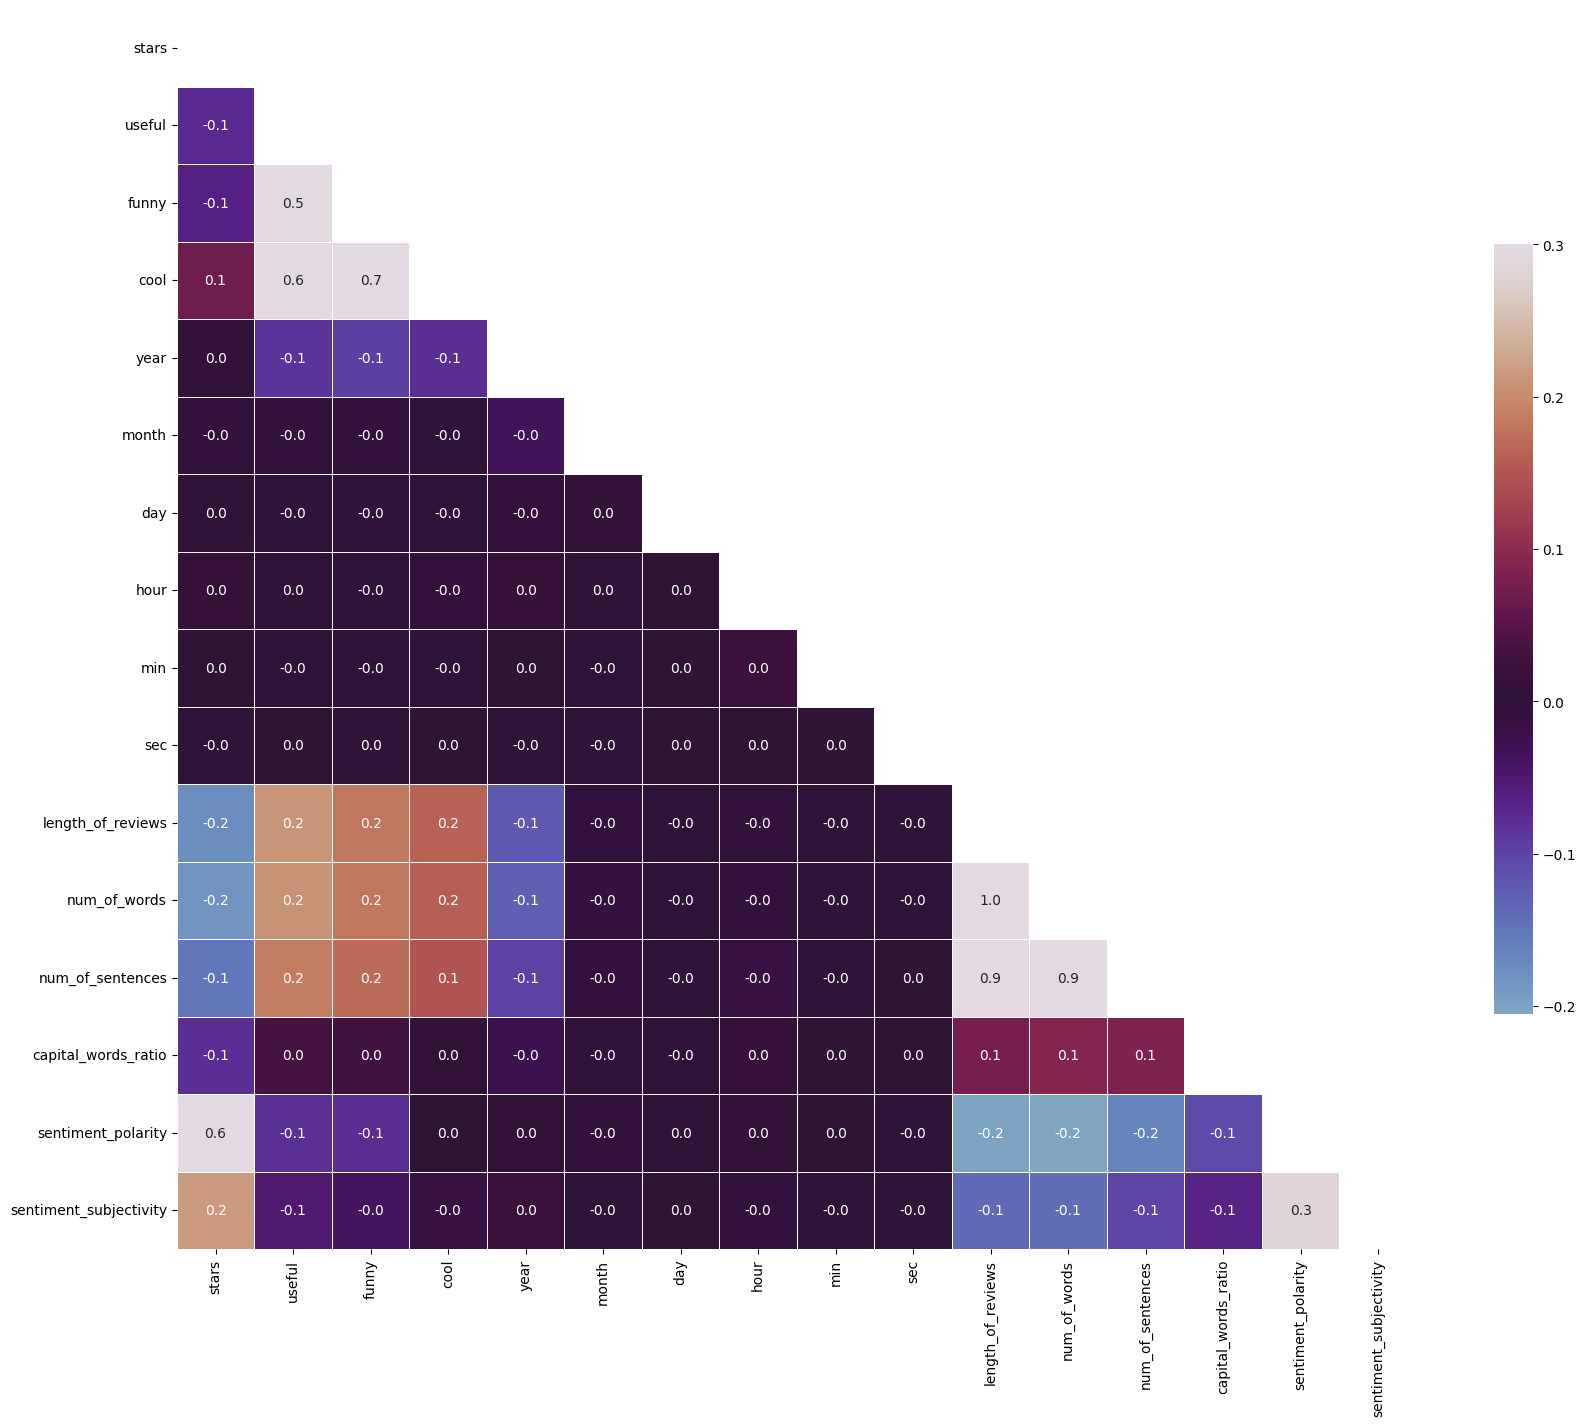

In [5]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, fmt=".1f", mask=mask, cmap='twilight', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [6]:
# CLASSIFICATION
data_classes = df[(df['stars']==1) | (df['stars']==3) | (df['stars']==5)]
print(data_classes.shape)

(1101761, 22)


In [7]:
X = data_classes.drop(columns=['stars', 'review_id', 'user_id', 'business_id', 'text', 'date', 'month', 'day', 'hour', 'min', 'cleaned_text'])
y = data_classes['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=0)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

### Model Selection

In [10]:
from sklearn.metrics import roc_curve, auc

In [11]:
plt.figure(figsize=(20, 20), dpi=100)
models = [ KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier(), xgb.XGBClassifier()]
names = ['KNeighbors', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'XGBoost']
colors = ['crimson', 'orange', 'gold', 'mediumseagreen', 'steelblue']
for i, ml in enumerate(models):
    ### train
    ml.fit(X_train, y_train)
    ### predict
    y_pred = ml.predict(X_test)
    
    print(ml, 'test accuracy:', ml.score(X_test, y_test))
    # print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test, y_pred))

KNeighborsClassifier() test accuracy: 0.7255993791779554
[[ 35107   4705   8549]
 [  8319   7072  19644]
 [  8610  10638 117709]]
DecisionTreeClassifier() test accuracy: 0.6713500610384248
[[ 31289   7615   9457]
 [  7183   9573  18279]
 [  9483  20402 107072]]
RandomForestClassifier() test accuracy: 0.7722018760806524
[[ 37362   2387   8612]
 [  6956   5517  22562]
 [  5506   4173 127278]]
GradientBoostingClassifier() test accuracy: 0.773672244081088
[[ 37506   2150   8705]
 [  7074   5002  22959]
 [  5596   3388 127973]]
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max

<Figure size 2000x2000 with 0 Axes>

In [15]:
clf = xgb.XGBClassifier()

clf.fit(X_train, y_train)

X_ = np.concatenate((X_train, X_test))
y_ = np.concatenate((y_train, y_test))

y_pred = clf.predict(X_)

print('Test accuracy:', clf.score(X_, y_))

print(confusion_matrix(y_, y_pred))

print(classification_report(y_, y_pred))

Test accuracy: 0.7805249958929387
[[189002  11638  40490]
 [ 33880  29224 111906]
 [ 26549  17346 641726]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77    241130
           1       0.50      0.17      0.25    175010
           2       0.81      0.94      0.87    685621

    accuracy                           0.78   1101761
   macro avg       0.69      0.63      0.63   1101761
weighted avg       0.75      0.78      0.75   1101761



### Filter out fake reviews

In [16]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2], dtype=int64), array([249431,  58208, 794122], dtype=int64))

In [17]:
final_df = data_classes.copy()
# convert encoder to original scale
final_df['pred_stars'] = le.inverse_transform(y_pred)
final_df = final_df[abs(final_df['pred_stars']-final_df['stars'])<4]
final_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,...,min,sec,length_of_reviews,num_of_words,num_of_sentences,capital_words_ratio,cleaned_text,sentiment_polarity,sentiment_subjectivity,pred_stars
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2018,...,9,11,513,114,7,0.026316,decide eat aware going take hours beginning en...,0.209722,0.419444,5
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,2012,...,28,18,829,174,7,0.011494,ive taken lot spin classes years nothing compa...,0.395455,0.571212,5
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015,...,1,3,243,56,6,0.000000,wow yummy different delicious favorite lamb cu...,0.279545,0.713068,5
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,2015,...,29,16,192,34,4,0.029412,amazingly amazing wings homemade bleu cheese r...,0.505556,0.788889,5
16,oyaMhzBSwfGgemSGuZCdwQ,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5,0,0,0,Tremendous service (Big shout out to Douglas) ...,2013-06-24 11:21:25,2013,...,21,25,276,51,2,0.000000,tremendous service big shout douglas complemen...,0.218750,0.641667,5


In [18]:
final_df.to_csv('data/review_data_without_fake.csv', index=False)